In [1]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from helpers import load_fixeddepth_summary

OUT_DIR = "../paper_figures/"
os.makedirs(OUT_DIR, exist_ok=True)

def add_panel_letter(ax, letter):
    ax.text(-0.0, 1.12, letter, transform=ax.transAxes, fontsize=12,
            fontweight="bold", va="top", ha="left")

# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}


# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.5, 1.0, 1.5, 2],
        fixed_frac      = [0.1, 0.25, 0.5, 0.75, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False, True],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D


def plot_peak_efficiency_vs_phi_panel(
    df, cache, ax=None, *,
    norm=None, cmap=None, add_cbar=False,
    axis_fs=10, tick_fs=9, rotate=15,
    add_baseline_legend=False, show_ylabel=True
):
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(2.6, 2.1), dpi=150); created_fig = True
    else:
        fig = ax.figure

    inter_all = df[df.variant != "without"].dropna(subset=["fixed_frac", "drop_strength"])
    ibl_rows  = inter_all[inter_all.intervention_baseline]
    inter     = inter_all[~inter_all.intervention_baseline]
    if inter.empty: return fig, ax

    phis = sorted(inter.fixed_frac.unique())
    lams = sorted(inter.drop_strength.unique())

    # Baseline-peak (idx,val) je (λ,tnf) + Fallback je λ
    pop = df.loc[df.variant=="without","pop"].iat[0]
    base_time_idx, base_time_val = {}, {}
    for key, summ in cache.items():
        if key[0] != "without": continue
        lam, tnf = key[2], key[5]
        inf = np.asarray(summ["infected_mean"]) / pop * 100.0
        idx = int(np.argmax(inf))
        base_time_idx[(lam, tnf)] = idx
        base_time_val[(lam, tnf)]  = float(inf[idx])
    base_time_idx_ds = {lam: idx for (lam,_), idx in base_time_idx.items()}
    base_time_val_ds = {lam: val for (lam,_), val in base_time_val.items()}

    if cmap is None or norm is None:
        cmap = plt.get_cmap("plasma"); norm = mcolors.Normalize(vmin=min(lams), vmax=max(lams))
    if add_cbar:
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = ax.figure.colorbar(sm, ax=ax, pad=0.02, fraction=0.05, aspect=30)
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    # Hauptlinien + SD
    all_means = []
    for lam in lams:
        y_line = [inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]["peak_efficiency"].mean()
                  for phi in phis]
        sds = []
        for phi in phis:
            sel = inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]
            if sel.empty: sds.append(np.nan); continue
            row = sel.iloc[0]; summ = cache[row["_key"]]
            tnf = row.get("top_node_frac", None)
            idx = base_time_idx.get((lam, tnf), base_time_idx_ds.get(lam))
            bvl = base_time_val.get((lam, tnf), base_time_val_ds.get(lam))
            if (idx is None) or (bvl in (None, 0)): sds.append(np.nan); continue
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            inf_at_idx = np.asarray(summ["infected_ts"][:, idx], float)/pop*100.0
            red_runs   = 100.0*(bvl - inf_at_idx)/bvl
            eff_runs   = np.where(mask, red_runs/eruns, np.nan)
            sds.append(np.nanstd(eff_runs, ddof=1))
        ax.plot(phis, y_line, '-', marker='o', ms=5, lw=1.8, color=cmap(norm(lam)))
        m, s = np.array(y_line,float), np.array(sds,float)
        ax.fill_between(phis, m-s, m+s, alpha=0.06, color=cmap(norm(lam)))
        all_means.extend(y_line)

    # Baseline (gestrichelt) + SD
    baseline_vals = []
    if not ibl_rows.empty:
        lam0 = sorted(ibl_rows.drop_strength.unique())[0]
        sel0 = ibl_rows[ibl_rows.drop_strength==lam0]
        phi_vals = sorted(sel0.fixed_frac.unique())
        y_vals   = [sel0[sel0.fixed_frac==φ]["peak_efficiency"].mean() for φ in phi_vals]

        s_base = []
        for φ in phi_vals:
            row = sel0[sel0.fixed_frac==φ].iloc[0]; summ = cache[row["_key"]]
            tnf = row.get("top_node_frac", None)
            idx = base_time_idx.get((lam0, tnf), base_time_idx_ds.get(lam0))
            bvl = base_time_val.get((lam0, tnf), base_time_val_ds.get(lam0))
            if (idx is None) or (bvl in (None,0)): s_base.append(np.nan); continue
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            inf_at_idx = np.asarray(summ["infected_ts"][:, idx], float)/pop*100.0
            red_runs   = 100.0*(bvl - inf_at_idx)/bvl
            eff_runs   = np.where(mask, red_runs/eruns, np.nan)
            s_base.append(np.nanstd(eff_runs, ddof=1))

        ax.plot(phi_vals, y_vals, '--', lw=1.0, color='grey', alpha=0.9,
                label="no threshold" if add_baseline_legend else None)
        ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
        s_base = np.array(s_base,float)
        ax.fill_between(phi_vals, np.array(y_vals)-s_base, np.array(y_vals)+s_base,
                        color='grey', alpha=0.12, zorder=0)
        baseline_vals.extend(y_vals)

    vals = all_means + baseline_vals
    if vals and not np.all(np.isnan(vals)):
        ymin, ymax = np.nanmin(vals), np.nanmax(vals)
        ax.set_ylim(bottom=max(0, 0.95*ymin), top=(1.05*ymax if ymax>0 else 1.0))

    if show_ylabel:
        ax.set_ylabel(r"Peak-efficiency ratio $\mathcal{E}_{\mathrm{peak}}$", fontsize=axis_fs, labelpad=2)
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"Removal fraction $\phi$", fontsize=axis_fs, labelpad=2)
    xticks = [0.1, 0.3, 0.5, 0.75, 1.0]; ax.set_xticks(xticks)
    ax.set_xticklabels([f"{φ:.2f}" for φ in xticks], fontsize=tick_fs)
    for t in ax.get_xticklabels(): t.set_rotation(rotate); t.set_ha('center'); t.set_rotation_mode('anchor')
    ax.tick_params(axis='y', labelsize=tick_fs); ax.grid(linestyle=':', alpha=0.5); ax.margins(x=0.03, y=0.05)
    if add_baseline_legend: ax.legend(frameon=False, fontsize=axis_fs-2, loc='upper right')
    if created_fig: fig.tight_layout()
    return fig, ax



def plot_attack_efficiency_vs_phi_panel(
    df, cache, ax=None, *,
    norm=None, cmap=None, add_cbar=False,
    axis_fs=10, tick_fs=9, rotate=15,
    add_baseline_legend=False, show_ylabel=True
):
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(2.6, 2.1), dpi=150); created_fig = True
    else:
        fig = ax.figure

    inter_all = df[df.variant != "without"].dropna(subset=["fixed_frac","drop_strength"])
    ibl_rows  = inter_all[inter_all.intervention_baseline]
    inter     = inter_all[~inter_all.intervention_baseline]
    if inter.empty: return fig, ax

    phis = sorted(inter.fixed_frac.unique())
    lams = sorted(inter.drop_strength.unique())
    base_inf_mean = df.loc[df.variant=="without","finf_abs"].mean()

    if cmap is None or norm is None:
        cmap = plt.get_cmap("plasma"); norm = mcolors.Normalize(vmin=min(lams), vmax=max(lams))
    if add_cbar:
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = ax.figure.colorbar(sm, ax=ax, pad=0.02, fraction=0.05, aspect=30)
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    all_means = []
    for lam in lams:
        y_line = [inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]["efficiency"].mean()
                  for phi in phis]
        sds = []
        for phi in phis:
            sel = inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]
            if sel.empty: sds.append(np.nan); continue
            row = sel.iloc[0]; summ = cache[row["_key"]]
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            finfr = np.asarray(summ["final_infected_abs_runs"], float)
            eff_runs = np.where(mask, 100.0*(base_inf_mean - finfr)/base_inf_mean / eruns, np.nan)
            sds.append(np.nanstd(eff_runs, ddof=1))
        ax.plot(phis, y_line, '-', marker='o', ms=5, lw=1.8, color=cmap(norm(lam)))
        m, s = np.array(y_line,float), np.array(sds,float)
        ax.fill_between(phis, m-s, m+s, alpha=0.06, color=cmap(norm(lam)))
        all_means.extend(y_line)

    # Baseline + SD
    baseline_vals = []
    if not ibl_rows.empty:
        lam0 = sorted(ibl_rows.drop_strength.unique())[0]
        sel0 = ibl_rows[ibl_rows.drop_strength==lam0]
        phi_vals = sorted(sel0.fixed_frac.unique())
        y_vals   = [sel0[sel0.fixed_frac==φ]["efficiency"].mean() for φ in phi_vals]

        s_base = []
        for φ in phi_vals:
            row = sel0[sel0.fixed_frac==φ].iloc[0]; summ = cache[row["_key"]]
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            finfr = np.asarray(summ["final_infected_abs_runs"], float)
            eff_runs = np.where(mask, 100.0*(base_inf_mean - finfr)/base_inf_mean / eruns, np.nan)
            s_base.append(np.nanstd(eff_runs, ddof=1))

        ax.plot(phi_vals, y_vals, '--', lw=1.0, color='grey', alpha=0.9,
                label="no threshold" if add_baseline_legend else None)
        ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
        s_base = np.array(s_base,float)
        ax.fill_between(phi_vals, np.array(y_vals)-s_base, np.array(y_vals)+s_base,
                        color='grey', alpha=0.12, zorder=0)
        baseline_vals.extend(y_vals)

    vals = all_means + baseline_vals
    if vals and not np.all(np.isnan(vals)):
        ymin, ymax = np.nanmin(vals), np.nanmax(vals)
        ax.set_ylim(bottom=max(0, 0.95*ymin), top=(1.05*ymax if ymax>0 else 1.0))

    if show_ylabel:
        ax.set_ylabel(r"Attack-rate efficiency $\mathcal{E}_{\mathrm{AR}}$", fontsize=axis_fs, labelpad=2)
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"Removal fraction $\phi$", fontsize=axis_fs, labelpad=2)
    xticks = [0.1, 0.3, 0.5, 0.75, 1.0]; ax.set_xticks(xticks)
    ax.set_xticklabels([f"{φ:.2f}" for φ in xticks], fontsize=tick_fs)
    for t in ax.get_xticklabels(): t.set_rotation(rotate); t.set_ha('center'); t.set_rotation_mode('anchor')
    ax.tick_params(axis='y', labelsize=tick_fs); ax.grid(linestyle=':', alpha=0.5); ax.margins(x=0.03, y=0.05)
    if add_baseline_legend: ax.legend(frameon=False, fontsize=axis_fs-2, loc='upper right')
    if created_fig: fig.tight_layout()
    return fig, ax


def plot_efficiency_bubble_panel(
    df, ax=None, *,
    norm=None, cmap=None,
    axis_fs=12, tick_fs=10,
    max_area=300, add_size_legend=True
):
    # exclude intervention_baseline rows here
    inter = (
        df[(df.variant != "without") & (~df.intervention_baseline)]
          .dropna(subset=["edges_removed_pct", "peak_reduced_pct", "fixed_frac", "drop_strength"])
    )
    if inter.empty: return (ax.figure if ax is not None else None), ax

    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.6, 3.0), dpi=150); created = True
    else:
        fig = ax.figure

    if cmap is None or norm is None:
        cmap = plt.get_cmap("plasma")
        dss  = sorted(inter.drop_strength.unique())
        norm = mcolors.Normalize(vmin=min(dss), vmax=max(dss))

    size_fn = lambda f: max_area * float(f)

    ax.scatter(
        inter["edges_removed_pct"].to_numpy(float),
        inter["peak_reduced_pct"].to_numpy(float),
        s=inter["fixed_frac"].map(size_fn),
        c=inter["drop_strength"].to_numpy(float),
        cmap=cmap, norm=norm,
        alpha=0.5, edgecolors="k", linewidths=0.4
    )

    ax.set_xlabel("Edges removed [%]", fontsize=axis_fs)
    ax.set_ylabel("Peak infection\nreduction [%]", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs); ax.grid(linestyle=":", alpha=0.5)
    ax.set_xlim(left=0); ax.set_ylim(bottom=0)

    if add_size_legend:
        fracs = sorted(inter.fixed_frac.unique())
        cand = [0.10, 0.50, 1.00]
        size_fracs = [f for f in cand if f in fracs] or [fracs[0], fracs[len(fracs)//2], fracs[-1]]
        handles = [Line2D([], [], marker="o", ls="", markerfacecolor="grey", markeredgecolor="k",
                          markersize=np.sqrt(size_fn(f)), alpha=0.6, label=fr"$\phi={f:.2f}$")
                   for f in size_fracs]
        ax.legend(handles=handles, frameon=False, fontsize=tick_fs, loc="lower right")

    if created: fig.tight_layout()
    return fig, ax


In [3]:
# ABM30
df_abm30, cache_abm30 = load_dataset("abm30")

# shared norm/cmap for λ based on this dataset
def build_lambda_norm_one(df, cmap_name="plasma"):
    lams = df[df.variant != "without"]["drop_strength"].unique()
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=float(np.nanmin(lams)), vmax=float(np.nanmax(lams)))
    return norm, cmap

norm30, cmap30 = build_lambda_norm_one(df_abm30, "plasma")


Loading abm30 …
Loading 4 baseline + 0 risk-depth + 29 fixed-depth files
✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem100_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip (from cache)   (1/33)
✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem50_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip (from cache)   (2/33)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem25_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip (from cache)   (3/33)
✓ results_without_ii24_ds100_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (4/33)
✓ results_without_ii24_ds150_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (5/33)
✓ results_without_ii24_ds50_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (

✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem75_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip   (23/33)
✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem25_tnfNA_ibl1_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip   (24/33)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem25_tnfNA_ibl1_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip   (25/33)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem75_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip   (26/33)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem100_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip   (27/33)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem50_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip   (28/33)
✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem100_tnfNA_ibl1_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p0

/tmp/ipykernel_2414176/4147824898.py:98: UserWarning: You passed a edgecolor/edgecolors ('grey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
/tmp/ipykernel_2414176/4147824898.py:191: UserWarning: You passed a edgecolor/edgecolors ('grey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)


✓ saved Fig9.tif


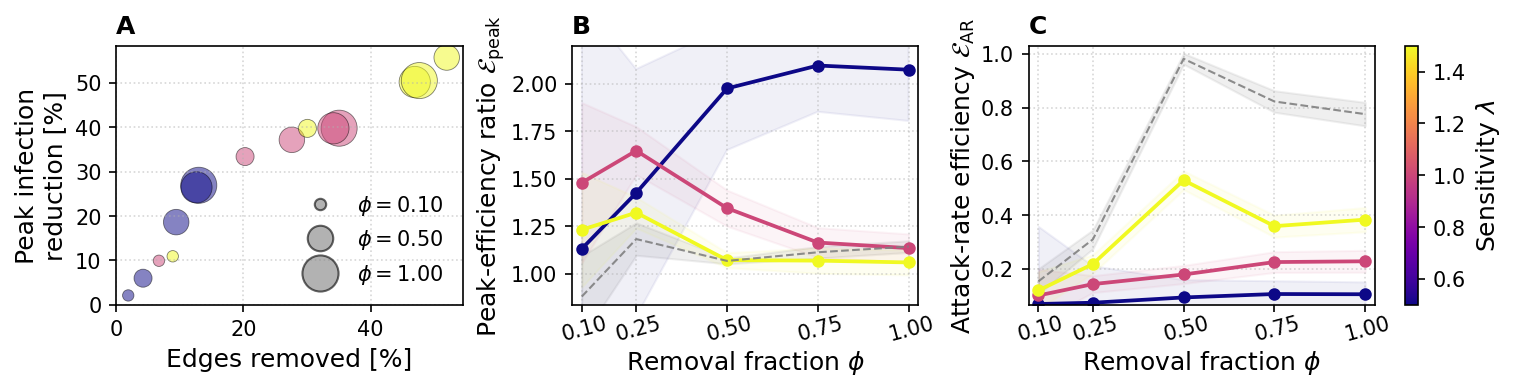

In [4]:
# 1×3 layout
fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), dpi=150, constrained_layout=True)

# A — bubble (no SD shading)
plot_efficiency_bubble_panel(
    df_abm30, ax=axes[0], norm=norm30, cmap=cmap30,
    axis_fs=12, tick_fs=10, add_size_legend=True
)

# B — peak-efficiency with SD shading (your new function)
plot_peak_efficiency_vs_phi_panel(
    df_abm30, cache_abm30, ax=axes[1],
    norm=norm30, cmap=cmap30, add_cbar=False,
    axis_fs=12, tick_fs=10, rotate=15,
    add_baseline_legend=False, show_ylabel=True
)

# C — attack-rate efficiency with SD shading (your new function)
plot_attack_efficiency_vs_phi_panel(
    df_abm30, cache_abm30, ax=axes[2],
    norm=norm30, cmap=cmap30, add_cbar=False,
    axis_fs=12, tick_fs=10, rotate=15,
    add_baseline_legend=False, show_ylabel=True
)

# ABM30 uses nicer φ ticks at 0.10, 0.25, 0.50, 0.75, 1.00
xt = [0.10, 0.25, 0.50, 0.75, 1.00]
for ax in (axes[1], axes[2]):
    ax.set_xticks(xt)
    ax.set_xticklabels([f"{x:.2f}" for x in xt])
    for t in ax.get_xticklabels():
        t.set_rotation(15); t.set_ha("center"); t.set_rotation_mode("anchor")

# shared λ colorbar for all three panels
sm = ScalarMappable(norm=norm30, cmap=cmap30); sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location="right", fraction=0.05, pad=0.01, aspect=20)
cbar.set_label(r"Sensitivity $\lambda$", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# panel letters
for ax, L in zip(axes, "ABC"):
    add_panel_letter(ax, L)

# save (PLOS-friendly 600 dpi)
fig.savefig(
    OUT_DIR + "9.tif",
    dpi=600, format="tiff",
    pil_kwargs={"compression": "tiff_lzw"},
    bbox_inches="tight"
)
print("✓ saved Fig9.tif")
